## Import depecdencies

In [120]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import os.path as osp

import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler

from plottable import ColumnDefinition
from plottable import Table
from plottable.formatters import decimal_to_percent

scaler = MinMaxScaler()


## Utils

In [4]:
# Define a function to find the index of the maximum value in a list
def argmax_list(lst):
    return max(range(len(lst)), key=lst.__getitem__)

# def plot_density(path="img.png", dataframes=[], target_col=None, colors=[], labels=[], title="", show=False):
#     plt.figure()  # Create a new figure for each plot
#     sns.set_theme(style="darkgrid")
#     for i, df in enumerate(dataframes):
#         sns.kdeplot(df[target_col], fill=True, color=colors[i], label=labels[i])
#     plt.legend()
#     plt.title(title)
#     plt.savefig(path)
#     if show:
#         plt.show()
    # plt.close()

## Metric | Correctness

In [5]:
class Correctness:
    def __init__(self, base_dir, phases, folds, epochs, epoch_skip=0, raw_dataset_path=""):
        self.base_dir       = base_dir
        self.phases         = phases
        self.folds          = folds
        self.epochs         = epochs
        self.epoch_skip     = epoch_skip
        self.dataset_info   = pd.read_csv(raw_dataset_path)
        self.metric_name    = "correctness"

    def calculate_auc_per_phase(self, correctness):
        result = {}
        for phase in self.phases:
            phase_correctness = correctness[correctness['phase'] == phase]
            merged_df = pd.merge(phase_correctness, self.dataset_info[['index', 'true_label']], left_on='sample', right_on='index', how='inner')
            y_true = merged_df['true_label'] == merged_df['label']
            if len(y_true.unique()) <=1:
                result[phase] = None
            else:
                auc_score = roc_auc_score(y_true=y_true, y_score = merged_df[self.metric_name])
                result[phase] = auc_score
        return result


    def calculate_correctness_per_phase(self, scale=False):
        correctness = pd.DataFrame()
        for phase in self.phases:
            res = self.calculate_correctness_on_folds(phase)
            res['phase'] = phase
            if scale:
                res[self.metric_name] = scaler.fit_transform(res[[self.metric_name]])
            correctness = correctness._append(res, ignore_index = True)
        correctness = correctness.groupby(['sample', 'label', 'phase'])[self.metric_name].sum().reset_index()
        return correctness


    def calculate_correctness_on_folds(self, phase):
        correctness = pd.DataFrame()
        for fold in range(self.folds):
            res = self.calculate_correctness_on_epochs(fold, phase)
            correctness = correctness._append(res, ignore_index = True)
        correctness = correctness.groupby(['sample', 'label'])[self.metric_name].sum().reset_index()
        return correctness


    def calculate_correctness_on_epochs(self, fold, phase):
        samples_data = pd.DataFrame()
        for epoch in range(self.epoch_skip, self.epochs):
            epoch = f"{epoch :03d}"
            glob_regex = osp.join(self.base_dir, str(fold), str(phase), str(epoch), '*.pd')
            iterations_log = sorted(glob.glob(glob_regex))
            if len(iterations_log) == 0:
                continue
            iterations_log = [pd.read_pickle(file_path) for file_path in iterations_log]
            iterations_log = pd.concat(iterations_log, axis=0, ignore_index=True)

            iterations_log = iterations_log.drop(columns=['loss'])
            iterations_log['prediction'] = iterations_log['proba'].apply(lambda x: argmax_list(x))
            iterations_log = iterations_log.drop(columns=['proba'])
            iterations_log[self.metric_name] = iterations_log['label'] == iterations_log['prediction']
            iterations_log = iterations_log.drop(columns=['prediction'])
            samples_data = samples_data._append(iterations_log, ignore_index=True)
        correctness = samples_data.groupby(['sample', 'label'])[self.metric_name].sum().reset_index()
        return correctness



## Run

In [34]:
def load_examins_auc(path, index_col):
    examines_with_corretness_auc = None
    try:
        examines_with_corretness_auc = pd.read_csv(path, index_col=index_col)
    except Exception as e :
        print(e)
    return examines_with_corretness_auc

def filter_out_auc_calculated_examins(examines, examines_with_corretness_auc):
    examines['has_auc'] = False
    for idx in examines_with_corretness_auc.index:
        if idx in examines.index:
            examines.loc[idx, 'has_auc'] = True
    
    return examines[(examines['has_auc'] == False)]

In [ ]:
metric_name = 'correctness'

base_dir = "/home/vision/Repo/cleanset/logs"
cols = ["dataset", "model", "optim", "init", "lr_scheduler", "np", "ns", "lr" ]
examines = pd.read_csv(osp.join(base_dir, "examines.csv"), index_col='index')
examines = examines[(examines['done'] == True)]
examines_with_corretness_auc = load_examins_auc(osp.join(base_dir,f"{metric_name}_auc.csv"), index_col='index')

if not examines_with_corretness_auc.empty:
    examines = filter_out_auc_calculated_examins(examines, examines_with_corretness_auc)


for phase in ['train', 'validation']:
    examines[f"{metric_name}-{phase}-auc"] = 0.0

for index, row in examines.iterrows():
    metric = Correctness(
        base_dir=osp.join(base_dir, *[str(row[col]) for col in cols]),
        phases=['train', 'validation'],
        folds=row['folds'],
        epochs=row['epochs'],
        epoch_skip=2,
        raw_dataset_path=f"/home/vision/Repo/cleanset/dataset/{row['dataset']}/info.csv")
    correctness = metric.calculate_correctness_per_phase(scale=True)
    auc = metric.calculate_auc_per_phase(correctness)
    print(index, 'auc: ', auc)
    for phase in ['train', 'validation']:
        examines.at[index, f"{metric_name}-{phase}-auc"] = auc[phase]
        examines.at[index, f"has_auc"] = True


In [122]:
examines = examines[(examines["has_auc"] == True)]
if not examines_with_corretness_auc.empty:
    examines_with_corretness_auc = examines_with_corretness_auc._append(examines.drop(columns=['has_auc']))
    examines_with_corretness_auc.to_csv(osp.join(base_dir, f"{metric_name}_auc.csv"))
else:
    examines.to_csv(osp.join(base_dir, f"{metric_name}_auc.csv"))

## Best Setting

In [123]:
import seaborn as sns
import matplotlib.pyplot as plt
from plottable import Table
from plottable import ColumnDefinition
from matplotlib import rc
from matplotlib.cm import Greens, Reds
from plottable.formatters import decimal_to_percent

In [124]:
metric_name = 'correctness'
base_dir = "/home/vision/Repo/cleanset/logs"
table = pd.read_csv(osp.join(base_dir, f"{metric_name}_auc.csv"), index_col='index')
table = table.dropna()

In [125]:
train_max_auc_rows = table.loc[table.groupby(['np', 'ns'])[f'{metric_name}-train-auc'].idxmax()]
val_max_auc_rows = table.loc[table.groupby(['np', 'ns'])[f'{metric_name}-validation-auc'].idxmax()]

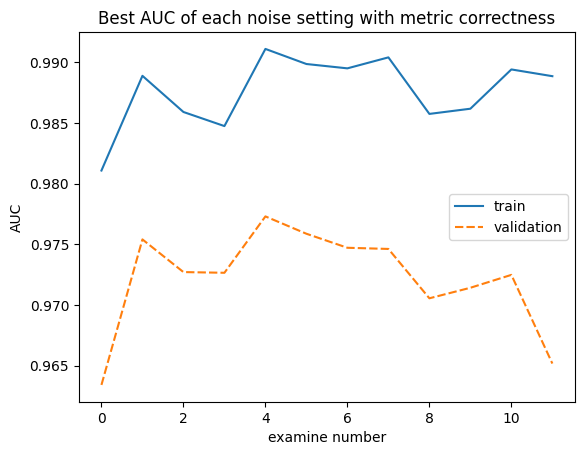

In [126]:
plt.title(f'Best AUC of each noise setting with metric {metric_name}')
sns.lineplot(data=pd.DataFrame({'train': train_max_auc_rows.reset_index()[f'{metric_name}-train-auc'], 'validation': val_max_auc_rows.reset_index()[f'{metric_name}-validation-auc']}))
plt.xlabel('examine number')
plt.ylabel('AUC')
plt.show()
plt.close()

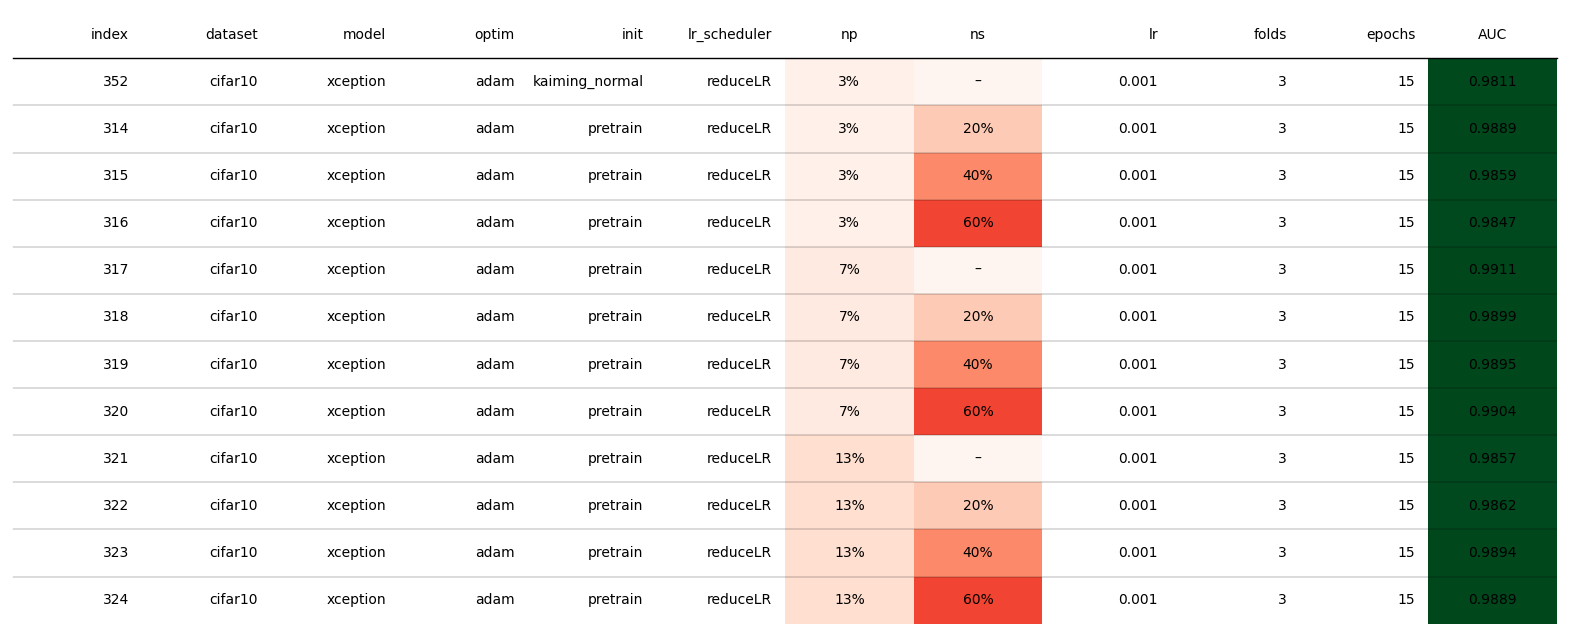

In [127]:
# Init a figure
fig, ax = plt.subplots(figsize=(20, 8))
df = train_max_auc_rows.copy()
df['np'] = train_max_auc_rows['np'].str.replace('np=', '').astype(float)
df['ns'] = train_max_auc_rows['ns'].str.replace('ns=', '').astype(float)
df['lr'] = train_max_auc_rows['lr'].str.replace('lr=', '').astype(float)
df['AUC'] = train_max_auc_rows['correctness-train-auc'].round(4)
df = df.drop(columns=[f'{metric_name}-train-auc', f'{metric_name}-validation-auc', 'done'])

tab = Table(df, column_definitions=[
    ColumnDefinition(name="AUC", cmap=Greens, textprops= {"ha": "center"}),
    ColumnDefinition(name="np", cmap=Reds, textprops={"ha": "center"}, formatter=decimal_to_percent),
    ColumnDefinition(name="ns", cmap=Reds, textprops={"ha": "center"}, formatter=decimal_to_percent)
])

# Display the output
plt.show()

In [128]:
print(df.index)

Index([352, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324], dtype='int64', name='index')
